## Strategy Idea 1 : "BSP Hedging"

__Section 0: Setup__ Importing packages/reading in data etc.

__Section 1 : Idea__ 

- __1.1__ Strategy idea

- __1.2__ Origin of idea. Context/Reasoning for strategy to work e.g. use in financial markets?

__Section 2 : Exploration__

- __2.1__ Exploratory Data Analysis. e.g plots of price/volumes that could show strategy working, how much potential.

- __2.2__ Define some 'strategy metrics'. Metrics that can can you use to gauge if this strategy will work i.e no.price points above a certain threshold that is profitable. Metrics could show how often there is an opportunity to make a trade and how much 'value' is in an opportunity e.g. how much is there a price swing?


__Section 3 : Strategy testing__

- __3.1__ Testing strategy on previous data. 

- __3.2__ State any assumptions made by testing.

- __3.3__ Model refinements. How could strategy be optimised? Careful : is this backfitting/overfitting - what measures taken to negate this e.g. bootstrapping?

- __3.4__ Assessing strategy. P/L on data sample? ROI? variance in results? longest losing run?

__Section 4 : Practical requirements__

- __4.1__ Identify if this edge is ‘realisable’? What methods will you apply to extract this value? e.g. applying a hedge function


- __4.2__ Is it possible to quantify the potential profit from the strategy? Consideration : How long will it take to obtain this? How 'risky' is it? e.g. if something did go wrong, how much do we lose? 

- __4.3__ Strategy limitations. The factors that could prevent strategy working e.g. practical considerations e.g. reacting quick enough to market updates, volume behind a price, size of bankroll needed


__Section 5: Potential limitations__

- __5.1__ What is our 'competition' - if not quantifiable, do we suspect people are doing the same thing? 

- __5.2__ So what's our edge? Identify ways of finding this edge in future? e.g what features are there? Are they predictive? Is there a certain 'market/runner' profile?





### Section 0 : Setup

In [2]:
# importing packages
from pathlib import Path, PurePath 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import utils

In [31]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# reading in data
project_dir = Path.cwd().parents[2]
data_dir = project_dir / 'data' / 'processed' / 'api' / 'advanced' / 'adv_data.csv'
df = pd.read_csv(data_dir, index_col = 0)
print(df.shape)
df.head()

(13073, 307)


,SelectionId,MarketId,Venue,Distance,RaceType,BSP,NoRunners,BS:T-60,BS:T-59,BS:T-58,...,LS:T+5,LS:T+6,LS:T+7,LS:T+8,LS:T+9,LS:T+10,LS:T+11,LS:T+12,LS:T+13,LS:T+14
0,11986132,1.169028,Huntingdon,20.0,Chase,8.33,9,16.43,24.51,26.57,...,10.08,11.15,5.44,7.09,14.16,19.53,3.12,3.31,0.68,0.68
1,16800725,1.169028,Huntingdon,20.0,Chase,3.68,9,15.43,25.74,57.82,...,29.87,221.22,43.23,43.10,13.53,26.15,13.60,74.30,419.52,23082.10
2,20968322,1.169028,Huntingdon,20.0,Chase,14.96,9,9.87,9.25,9.15,...,37.32,6.83,4.85,11.23,16.00,5.68,40.25,12.51,10.42,13.17
3,22023486,1.169028,Huntingdon,20.0,Chase,4.25,9,84.38,64.49,58.01,...,11.67,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02
4,24496216,1.169028,Huntingdon,20.0,Chase,6.60,9,10.64,10.11,7.91,...,34.27,54.72,11.85,17.99,48.21,17.28,38.29,6.96,4.37,4.37


In [4]:
# defining variables
back_prices = [col for col in df.columns if 'BP' in col]
back_sizes = [col for col in df.columns if 'BS' in col]
lay_prices = [col for col in df.columns if 'LP' in col]
lay_sizes = [col for col in df.columns if 'LS' in col]

runner_info = ['SelectionId', 'MarketId', 'Venue', 'Distance', 'RaceType', 'BSP', 'NoRunners']

In [45]:
def plot_df():
    plot_df = df[(df['BSP'].notna()) & (df['BSP'] < 2)].sample(1).copy() # 60 NA BSP's

    bp_df = plot_df[['SelectionId'] + back_prices].copy()
    new_cols = bp_df.columns.str.replace("[BP:T]", "").str.replace("[+]", "")
    bp_df.rename(columns = dict(zip(bp_df.columns, new_cols)), inplace = True)
    bp_df = pd.melt(bp_df, id_vars = ['SelectionId'])
    bp_df['variable'] = bp_df['variable'].astype(int)

    lp_df = plot_df[['SelectionId'] + lay_prices].copy()
    new_cols = lp_df.columns.str.replace("[LP:T]", "").str.replace("[+]", "")
    lp_df.rename(columns = dict(zip(lp_df.columns, new_cols)), inplace = True)
    lp_df = pd.melt(lp_df, id_vars = ['SelectionId'])
    lp_df['variable'] = lp_df['variable'].astype(int)

    bsp_df = plot_df[['BSP']].copy()
    bsp_df['min_bp'] = bsp_df['BSP'].apply(lambda x: round(utils.back_hedge_min_bp(x, 0.05), 2))
    bsp_df['max_lp'] = bsp_df['BSP'].apply(lambda x: round(utils.lay_hedge_max_lp(x, 0.05), 2))    
    
    return bp_df, lp_df, bsp_df

### Section 1 : Idea

Similar to 1_BSP_hedging_inplay, yet looking for variation pre-race and placing 2nd bet at BSP as opposed to first bet

### Section 2 : Exploration

__2.1__ Plots

To explore this phenomena (of price variation in comparison to BSP) plots of the back price and lay price throughout the time of race are shown below: 

__Plot of Back/Lay Price by Runner__

Taking a random runner from the sample and plotting their Back and Lay price over time. 

We are interested in how many time a horse's price goes above/below the red dotted line before Time == 0, when the race starts. The red dotted line displays the Betfair Starting Price which the back & lay price you can guarantee yourself before the start of the race. Th 

Note : every time you run the cell a different runner will be chosen to plot - spam CTRL + ENTER

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25]),
 <a list of 10 Text major ticklabel objects>)

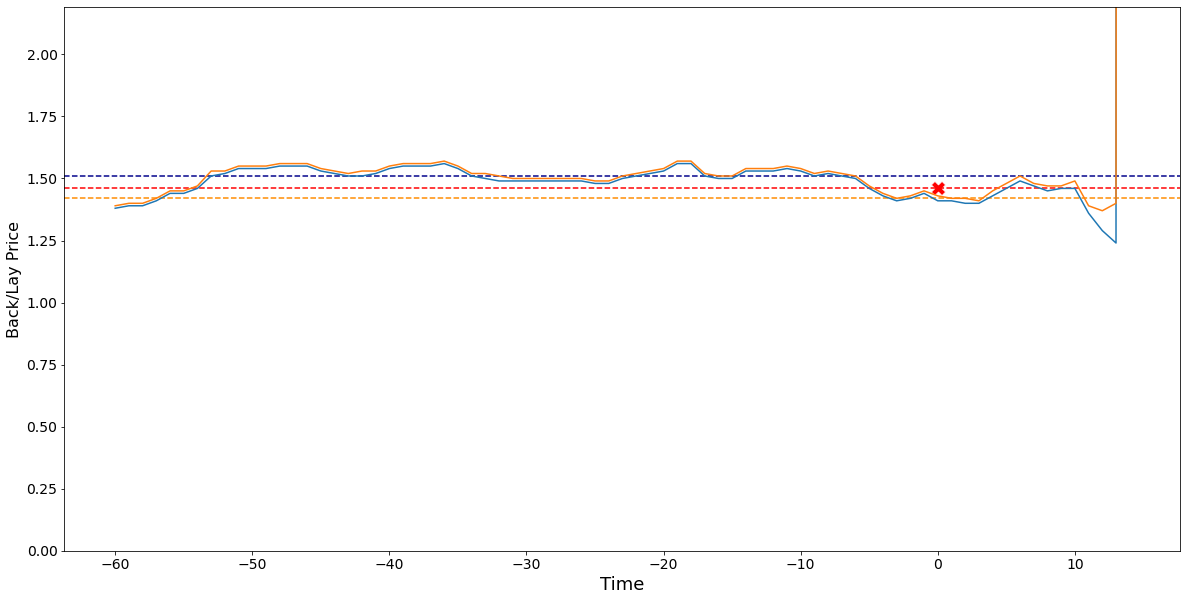

In [73]:
bp_df, lp_df, bsp_df = plot_df()

# set plotting parameters
plt.figure(figsize=(20,10))
plt.ylim(0, bsp_df['BSP'].item() * 1.5) # limit y axis

# plotting
sns.scatterplot(0, y = bsp_df['BSP'], marker = 'X', s=200, color = 'r')
plt.axhline(y=bsp_df['BSP'].item(), color='r', linestyle='--')
plt.axhline(y=bsp_df['max_lp'].item(), color='darkorange', linestyle='--')
plt.axhline(y=bsp_df['min_bp'].item(), color='darkblue', linestyle='--')

sns.lineplot(x = 'variable', y = 'value', data = bp_df, ci = None)

sns.lineplot(x = 'variable', y = 'value', data = lp_df, ci = None)

# plot formatting
plt.xlabel('Time', fontsize=18)
plt.ylabel('Back/Lay Price', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

As shown above, there are many example whereby the inplay back/lay price fluctuates below/above the guaranteed BSP - this is good news! 

However, what we are most interest in is how to extract most value from this insight by quanitfying how often this occurs - we need some metrics...
___

__2.2 Metrics__

To determine the potential success of this strategy we need to consider three things:
- (1) The probability of the pre race price reaching a profitable level
- (2) The probability of your pre race bet being matched
- (3) The profit that can be made if prices reaches/exceeds this level
- (4) The loss incurred if the price doesn't reach this level and the trade isn't match
    
The strategy would look something like this:
- We place sepeaate lay and back orders into the market as the race starts
- We back/lay at the second part of the hedge bet at BSP 
- The orders are placed at at least the minimum price difference from the BSP needed to make a profitable hedge
    
(We are effectively testing out two strategies at once, Back to then Lay and Lay to then Back)

___

To get an initial idea of the potential success of this strategy we'll initially just investigate the following:


__Metric 1__ : How often does an prerace back price exceed the BSP per runner?

__Metric 2__ : How often does an prerace lay price go below the BSP per runner?

This is good but what we're really interest in is the amount by which these prices increase/decrease by and if these differences are profitable enough...

__Metric 3__ : If prerace BP goes above bsp, how often does it go higher than min hedge price?

__Metric 4__ : If prerace LP went below bsp, how often does it go lower than max hedge price?

Further to this, how often do these events happen together for a single runner?

__Metric 5__ : How often so __Metric 3__ & __Metric 4__ occur together?
  
  
(Worth adding a metric to look into how far above/below min hedge price?)

In [8]:
test_df = df[back_prices + lay_prices + ['BSP']].copy()

bp_start = test_df.columns.get_loc("BP:T-60")
bp_end = test_df.columns.get_loc("BP:T-1") + 1

lp_start = test_df.columns.get_loc("LP:T-60")
lp_end = test_df.columns.get_loc("LP:T-1") + 1

In [9]:
test_df['m1'] = test_df.iloc[:,bp_start:bp_end].gt(test_df['BSP'],axis=0).sum(axis=1)

In [10]:
test_df['m2'] = test_df.iloc[:,lp_start:lp_end].lt(test_df['BSP'],axis=0).sum(axis=1)

In [11]:
test_df['bp_min'] = test_df['BSP'].apply(lambda x: round(utils.back_hedge_min_bp(x, 0.05), 2))
test_df['m3'] = test_df.iloc[:,bp_start:bp_end].gt(test_df['bp_min'],axis=0).sum(axis=1)

In [12]:
test_df['lp_min'] = test_df['BSP'].apply(lambda x: round(utils.lay_hedge_max_lp(x, 0.05), 2))
test_df['m4'] = test_df.iloc[:,lp_start:lp_end].lt(test_df['lp_min'],axis=0).sum(axis=1)

In [13]:
test_df['m5'] = np.where((test_df['m3'] > 0) & (test_df['m4'] > 0), 1, 0)

In [17]:
print('M1 : % runners with an pre race BP surpassing the BSP = ',
      round(len(test_df.loc[test_df['m1'] > 0].index) / len(test_df.index) * 100, 2), "%")

print('M2 : % runners with an pre race LP surpassing the BSP = ',
      round(len(test_df.loc[test_df['m2'] > 0].index) / len(test_df.index) * 100, 2), "%")

print('M3 : % runners with an pre race BP surpassing the min profitable hedge threshold = ',
      round(len(test_df.loc[test_df['m3'] > 0].index) / len(test_df.index) * 100, 2), "%")

print('M4 : % runners with an pre race LP surpassing the max profitable hedge threshold = ',
      round(len(test_df.loc[test_df['m4'] > 0].index) / len(test_df.index) * 100, 2), "%")

print('M5 : % runners who "pass" m3 AND m4 simultaneously =',
      round(len(test_df.loc[test_df['m5'] ==1].index) / len(test_df.index) * 100, 2), "%")

M1 : % runners with an pre race BP surpassing the BSP =  77.14 %
M2 : % runners with an pre race LP surpassing the BSP =  81.22 %
M3 : % runners with an pre race BP surpassing the min profitable hedge threshold =  55.08 %
M4 : % runners with an pre race LP surpassing the max profitable hedge threshold =  61.49 %
M5 : % runners who "pass" m3 AND m4 simultaneously = 20.19 %


### Comparing m3 / m4 metric by price

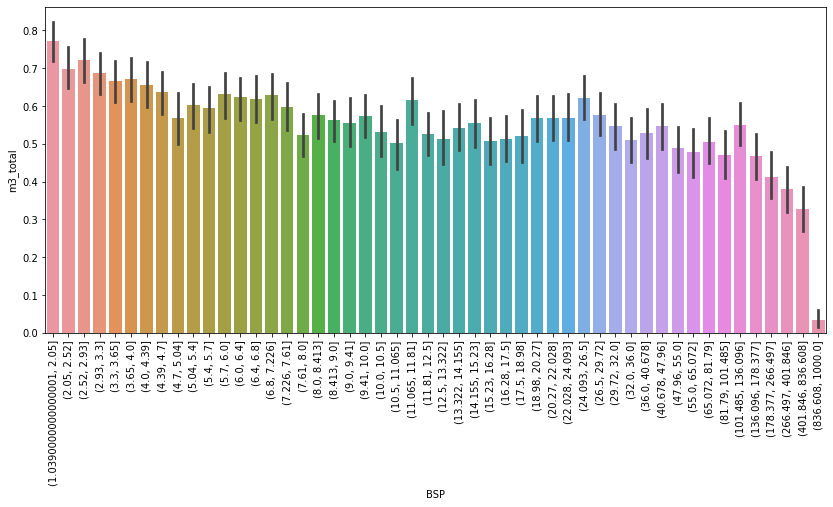

In [20]:
test_df['m3_total'] = np.where(test_df['m3'] > 0, 1, 0)
plt.figure(figsize=(14,6))
plt.xticks(rotation=90)
# sns.distplot(test_df['BSP'], test_df['m3_total'])
vals = pd.qcut(test_df['BSP'], 50)
sns.barplot(vals, test_df['m3_total'])

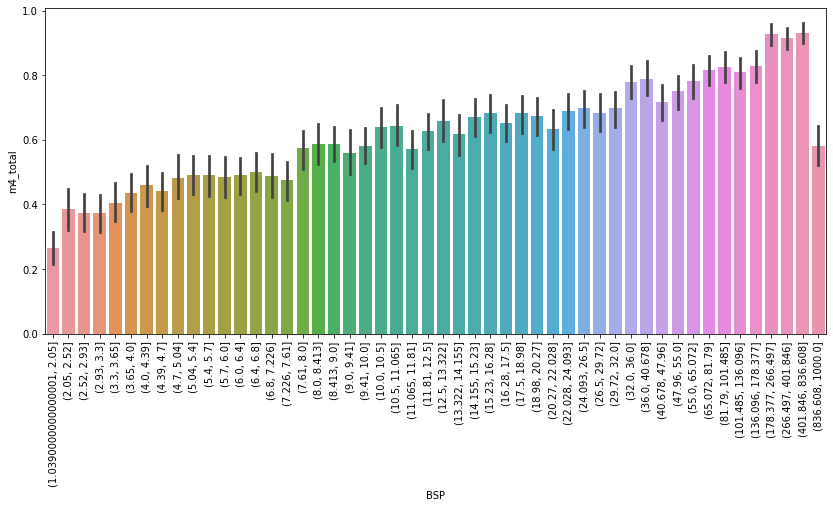

In [22]:
test_df['m4_total'] = np.where(test_df['m4'] > 0, 1, 0)
plt.figure(figsize=(14,6))
plt.xticks(rotation=90)
# sns.distplot(test_df['BSP'], test_df['m3_total'])
vals = pd.qcut(test_df['BSP'], 50)
sns.barplot(vals, test_df['m4_total'])

*surpassing the BSP at at least one inplay standardised time interval (15 maximum). 

### Comparing m3 / m4 metric by time
i.e. we know at least one time point pre race is available for a profitable hedge but at what time pre race does this occur, is it random?

In [ ]:
# count of T's that surpass min hedge thresholds

In [32]:
# correaltion measures between bsp and T's
test_df[back_prices + ['BSP']].corr().tail(1) # indicates ealier less correlated..

,BP:T-60,BP:T-59,BP:T-58,BP:T-57,BP:T-56,BP:T-55,BP:T-54,BP:T-53,BP:T-52,BP:T-51,BP:T-50,BP:T-49,BP:T-48,BP:T-47,BP:T-46,BP:T-45,BP:T-44,BP:T-43,BP:T-42,BP:T-41,BP:T-40,BP:T-39,BP:T-38,BP:T-37,BP:T-36,BP:T-35,BP:T-34,BP:T-33,BP:T-32,BP:T-31,BP:T-30,BP:T-29,BP:T-28,BP:T-27,BP:T-26,BP:T-25,BP:T-24,BP:T-23,BP:T-22,BP:T-21,BP:T-20,BP:T-19,BP:T-18,BP:T-17,BP:T-16,BP:T-15,BP:T-14,BP:T-13,BP:T-12,BP:T-11,BP:T-10,BP:T-9,BP:T-8,BP:T-7,BP:T-6,BP:T-5,BP:T-4,BP:T-3,BP:T-2,BP:T-1,BP:T+0,BP:T+1,BP:T+2,BP:T+3,BP:T+4,BP:T+5,BP:T+6,BP:T+7,BP:T+8,BP:T+9,BP:T+10,BP:T+11,BP:T+12,BP:T+13,BP:T+14,BSP
BSP,0.87649,0.879246,0.883366,0.885356,0.886612,0.887307,0.888202,0.891193,0.893449,0.895935,0.896644,0.898479,0.900018,0.900468,0.902101,0.904066,0.905432,0.907446,0.908397,0.90921,0.910339,0.911584,0.912897,0.914326,0.915257,0.917195,0.919446,0.920521,0.920823,0.921787,0.923152,0.92409,0.924637,0.926055,0.92707,0.928607,0.930397,0.931572,0.932386,0.933414,0.935534,0.938054,0.939666,0.94127,0.942887,0.944904,0.946684,0.947892,0.949845,0.951656,0.953673,0.955759,0.958687,0.96308,0.966353,0.971587,0.976666,0.982907,0.988886,0.992994,0.931944,0.859077,0.810178,0.764462,0.729314,0.686188,0.646423,0.604533,0.554926,0.510215,0.463169,0.41534,0.358512,0.293112,0.20562,1.0


### Leaving this for now...

We know this strategy prevents the need of a stop loss, however will focus on inplay markets for now due to more opportunity of profitable bets...

---
---
---

### Strategy

Idea : Continually compare current price to prediction of BSP and place trade if difference is 'hedgeable enough'

What factors could help predict BSP?

- BSP itself
- Volumes
- Other price swings



In [ ]:
# assumptions over volume behind price should really be included
# as easy as saying applying hedge func -> create new columnn referring to LS/BS

In [ ]:
#To do
# when tweaking results e.g. as % increases, less likely to find a match/be profitable 
# ...- where is a good cutoff -plot!

# triple check hedge functions works correctly

# find an interesting inplay price pattern watch races for undestanding

# format notebook

# think about how to know what the BSP will be... model needed! build into strat too?
# may just be as easy (or predictable enough) as X% above T-60 price point?, liekly differs by BSP 
#... e.g. can't exceed 1000

In [ ]:
Features/Models
- specialisation - what is our biggest advantage over others? ML - specific market finding?
